# Starting Kit - FAIR UNIVERSE: HIGGSML UNCERTAINTY CHALLENGE

For Overview and Decsiptions of the competition, please visit the competition page

***
# Setup
***
`COLAB` determines whether this notebook is running on Google Colab.

In [1]:
COLAB = 'google.colab' in str(get_ipython())

In [2]:
if COLAB:
    # clone github repo
    !git clone https://github.com/FAIR-Universe/HEP-Challenge.git
    !pip install iminuit

    # move to the HEP starting kit folder
    %cd HEP-Challenge/

`USE_PUBLIC_DATA` determines whether to use a public dataset provided for the participants or use a small subset of the data for quick execution of this notebook

In [3]:
USE_PUBLIC_DATA = True

In [4]:
if USE_PUBLIC_DATA:
    
    # Download public data -- uncomment the next line to download public data (> 1 GB)
    !wget -O public_data.zip https://www.codabench.org/datasets/download/c73d1b99-e767-428e-a076-df16a7c95e10/
    
    # Unzip public data -- uncomment the next line to unzip the public data
    !unzip public_data.zip -d public_data

'wget' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.
'unzip' n’est pas reconnu en tant que commande interne
ou externe, un programme exécutable ou un fichier de commandes.


***
# Existing Submissions
***
By this point you should have a clone of the repo which contains `HiggsML_Dummy_Submission.zip` which you can submit to the Competition

For more sample submissions please check `/HEP-Challenge/example_submissions/`

***
# Imports
***

In [5]:
import os
from sys import path
import numpy as np
import pandas as pd
import json
import matplotlib.pyplot as plt
from itertools import product
from copy import deepcopy
from numpy.random import RandomState
import warnings
warnings.filterwarnings("ignore")

***
# Directories
***

In [6]:
root_dir = "./"
# Input data directory to read training data from
if USE_PUBLIC_DATA:
    input_dir = root_dir + "/public_data/"
    reference_dir = root_dir + '/public_data/'
else:
    input_dir = root_dir + "input_data/"
    reference_dir = root_dir + 'reference_data/'
# Output data directory to write predictions to
output_dir = root_dir + "sample_result_submission"
# Program directory
program_dir = root_dir + "ingestion_program"
# Score directory
score_dir = root_dir + "scoring_program"
# Directory to read submitted submissions from
submission_dir = root_dir + "sample_code_submission"

***
# Add directories to path
***

In [7]:
path.append(input_dir)
path.append(reference_dir)
path.append(output_dir)
path.append(program_dir)
path.append(submission_dir)

***
# Internal imports
***

In [8]:
from visualization import *
from systematics import Systematics

***
# Import Submission Model
***
We import a class named `Model` from the submission file (`model.py`). This `Model` class has the following methods:
- `init`: receives train set and systematics class as input
- `fit`: can be used for training
- `predict`: receives one test set and outputs a dictionary with the following keys
    - `mu_hat` : predicted mu $\hat{\mu}$
    - `delta_mu_hat`: $\Delta{\hat{\mu}}$ bound for $\mu$
    - `p16`: 16th percentile
    - `p84`: 84th percentile

In this example code, the `Model` class implements an XGBoost model which is trained to predict both the TES and the class label. You can find the code in `HEP-Challenge/sample_code_submission/model.py`. You can modify it the way you want, keeping the required class structure and functions there. More instructions are given inside the `model.py` file. If running in Collab, click the folder icon in the left sidebar to open the file browser.

### ⚠️ Note:
In real setting i.e. the challenge itself, the submitted model is initialized once with train set and systematics class and the `predict` is called multiple times, each time with a different test sets. 

In [9]:
from model_TF import Model

***
# Data
***
1. Load Train set
2. Load Test sets


### ⚠️ Note:
The data used here is sample data is for demonstration only to get a view of what the data looks like.

In [10]:
class Data():

  def __init__(self):

      self.train_set = None
      self.test_set = None
      self.systematics = Systematics
      self.NUM_SETS = 4

      self.test_dir = 'valid' if USE_PUBLIC_DATA else 'test' 

      print("==========================================")
      print("Data")
      print("==========================================")

  def load_train_set(self):
    """
      - Loads train set
      - Train set has no systematics
    """
    print("[*] Loading Train set")

    train_data_file = os.path.join(input_dir, 'train', 'data', 'data.parquet')
    train_labels_file = os.path.join(input_dir, 'train', 'labels', "data.labels")
    train_settings_file = os.path.join(input_dir, 'train', 'settings', "data.json")
    train_weights_file = os.path.join(input_dir, 'train', 'weights', "data.weights")

    # read train data
    train_data = pd.read_parquet(train_data_file, engine="pyarrow")

    # read train labels
    with open(train_labels_file, "r") as f:
        train_labels = np.array(f.read().splitlines(), dtype=float)

    # read train settings
    with open(train_settings_file) as f:
        train_settings = json.load(f)

    # read train weights
    with open(train_weights_file) as f:
        train_weights = np.array(f.read().splitlines(), dtype=float)

    self.train_set = {
        "data": train_data,
        "labels": train_labels,
        "settings": train_settings,
        "weights": train_weights
    }

  def load_test_set(self):
    """
      - Loads test set
    """
    print("[*] Loading Test set")
    test_data_file = os.path.join(input_dir, self.test_dir, 'data', 'data.parquet')
    test_labels_file = os.path.join(input_dir, self.test_dir, 'labels', "data.labels")
    test_weights_file = os.path.join(input_dir, self.test_dir, 'weights', "data.weights")

    # read test data
    test_data = pd.read_parquet(test_data_file, engine="pyarrow")

    # read test labels
    with open(test_labels_file, "r") as f:
        test_labels = np.array(f.read().splitlines(), dtype=float)


    # read test weights
    with open(test_weights_file) as f:
        test_weights = np.array(f.read().splitlines(), dtype=float)

    # test settings
    test_settings = {
        "ground_truth_mus": (np.random.uniform(0.1, 3, self.NUM_SETS)).tolist()
    }

    self.test_set = {
        "data": test_data,
        "labels": test_labels,
        "settings": test_settings,
        "weights": test_weights
    }

In [11]:
# Initilaize data
data = Data()

Data


In [12]:
# load train set
data.load_train_set()

[*] Loading Train set


In [13]:
# load test sets
data.load_test_set()

[*] Loading Test set


***
# Visualize
***
- Visualize Train set

In [14]:
class Visualize():

    def __init__(self, data):

        self.train_visualize = Dataset_visualise(
            data=data.train_set["data"],
            weights=data.train_set["weights"],
            labels=data.train_set["labels"],
            name="Train Set"
        )
        print("==========================================")
        print("Visualize")
        print("==========================================")


    def show_data_summary(self):
        """
            Show Dataset summary
                - Number of events
                - Number of features
                - Number of signal events
                - Number of background events
                - mean and std of each feature and other statistical information
        """
        self.train_visualize.examine_dataset()

    def show_histogram(self):
        """
            - plot the histogram of each feature in the dataset for signal and background events,
            - for given set of columns. Columns to be plotted can be specified by the user
            - This function will take a long time to run if the number of columns is large, 
            - If no columns are given it will plot all the columns of the dataset.
        """
        columns = ['PRI_jet_leading_pt', 'PRI_met', 'DER_mass_vis', 'DER_mass_jet_jet', 'DER_deltar_lep_had', 'DER_sum_pt']
        self.train_visualize.histogram_dataset(columns=columns)

    def show_pair_plots(self):
        """ 
            This function will plot the pair plots of the features in the dataset for the given columns 
            for the signal and background events separately

            NB: 
            - This function will take a long time to run if the number of columns is large, 
            - If no columns are given it will plot all the columns of the dataset.
        """
        columns = ['PRI_lep_pt', 'PRI_lep_eta','PRI_lep_phi', 'DER_deltar_had_lep']
        self.train_visualize.pair_plots(columns=columns)


In [15]:
# Initilaize Visualize
visualize = Visualize(data=data)

Visualize


In [16]:
# Show data summary
visualize.show_data_summary()

[*] --- Dataset name : Train Set
[*] --- Number of events : 12017472
[*] --- Number of features : 32
[*] --- Number of signal events : 6420728
[*] --- Number of background events : 5596744
[*] --- List of all features
	PRI_lep_pt
	PRI_lep_eta
	PRI_lep_phi
	PRI_electron_flag
	PRI_muon_flag
	PRI_had_pt
	PRI_had_eta
	PRI_had_phi
	PRI_jet_leading_pt
	PRI_jet_leading_eta
	PRI_jet_leading_phi
	PRI_n_jets
	PRI_jet_subleading_pt
	PRI_jet_subleading_eta
	PRI_jet_subleading_phi
	PRI_jet_all_pt
	PRI_met
	PRI_met_phi
	DER_mass_transverse_lep_had
	DER_mass_vis
	DER_pt_h
	DER_deltaeta_jet_jet
	DER_mass_jet_jet
	DER_prodeta_jet_jet
	DER_deltar_lep_had
	DER_pt_tot
	DER_sum_pt
	DER_pt_ratio_lep_had
	DER_mass_transverse_met_lep
	DER_deltar_had_lep
	DER_met_phi_centrality
	DER_lep_eta_centrality
[*] --- Examples of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_electron_flag,PRI_muon_flag,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,...,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_lep_had,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_mass_transverse_met_lep,DER_deltar_had_lep,DER_met_phi_centrality,DER_lep_eta_centrality
0,20.260000,-1.224,2.649,0.0,1.0,29.732000,-1.609,-0.192,29.732000,-1.609,...,-7.000000,-7.000,2.868,57.091999,49.992001,0.681,35.250000,2.868,1.337,-7.000
1,21.504000,-0.228,-2.105,1.0,0.0,48.828999,0.434,1.546,48.828999,0.434,...,255.746994,-1.490,2.715,45.999001,147.516998,0.440,5.019000,2.715,0.477,0.649
2,24.552999,-2.029,2.936,1.0,0.0,45.036999,-0.673,-0.230,45.036999,-0.673,...,-7.000000,-7.000,3.399,45.806999,69.589996,0.545,6.913000,3.399,-1.413,-7.000
3,34.629002,-0.243,1.022,0.0,1.0,40.568001,-1.032,-2.258,40.568001,-1.032,...,-7.000000,-7.000,3.105,42.723999,75.196999,0.854,19.891001,3.105,-1.413,-7.000
4,41.933998,2.174,-0.193,0.0,1.0,35.985001,0.429,2.301,35.985001,0.429,...,106.737999,1.243,3.043,36.543999,142.404007,1.165,4.671000,3.043,0.525,0.842


[*] --- Description of all features


,PRI_lep_pt,PRI_lep_eta,PRI_lep_phi,PRI_electron_flag,PRI_muon_flag,PRI_had_pt,PRI_had_eta,PRI_had_phi,PRI_jet_leading_pt,PRI_jet_leading_eta,...,DER_mass_jet_jet,DER_prodeta_jet_jet,DER_deltar_lep_had,DER_pt_tot,DER_sum_pt,DER_pt_ratio_lep_had,DER_mass_transverse_met_lep,DER_deltar_had_lep,DER_met_phi_centrality,DER_lep_eta_centrality
count,1.201747e+07,1.201747e+07,1.201747e+07,1.201747e+07,1.201747e+07,1.201747e+07,1.201747e+07,1.201747e+07,1.201747e+07,1.201747e+07,...,1.201747e+07,1.201747e+07,1.201747e+07,1.201747e+07,1.201747e+07,1.201747e+07,1.201747e+07,1.201747e+07,1.201747e+07,1.201747e+07
mean,3.291534e+01,1.449027e-04,-1.498656e-04,4.398219e-01,5.601781e-01,4.261626e+01,-2.249712e-03,-1.737185e-02,6.120762e+01,2.550981e-03,...,1.054439e+02,-3.372963e+00,2.636899e+00,5.277758e+01,1.529677e+02,8.806697e-01,2.030037e+01,2.636898e+00,4.291987e-01,-3.377616e+00
std,1.740596e+01,1.226966e+00,1.801570e+00,5.130612e-01,5.130612e-01,2.346307e+01,1.218660e+00,1.796802e+00,5.604258e+01,1.459856e+00,...,2.208017e+02,4.206491e+00,6.830901e-01,3.847154e+01,1.393285e+02,5.112140e-01,1.923880e+01,6.830901e-01,1.152985e+00,3.757514e+00
min,2.000000e+01,-2.500000e+00,-3.142000e+00,0.000000e+00,0.000000e+00,2.286900e+01,-2.695000e+00,-3.142000e+00,2.289100e+01,-4.998000e+00,...,-7.000000e+00,-2.359000e+01,3.840000e-01,1.700000e-02,4.304100e+01,1.500000e-02,-0.000000e+00,3.840000e-01,-1.414000e+00,-7.000000e+00
25%,2.367500e+01,-9.650000e-01,-1.582000e+00,0.000000e+00,0.000000e+00,3.011100e+01,-9.530000e-01,-1.598000e+00,3.303000e+01,-1.072000e+00,...,-7.000000e+00,-7.000000e+00,2.293000e+00,3.273800e+01,6.424800e+01,5.760000e-01,5.912000e+00,2.293000e+00,-1.072000e+00,-7.000000e+00
50%,2.837400e+01,3.000000e-03,2.000000e-03,0.000000e+00,1.000000e+00,3.706900e+01,-2.000000e-03,-3.300000e-02,4.221300e+01,-5.000000e-03,...,-7.000000e+00,-7.000000e+00,2.894000e+00,4.477700e+01,8.527500e+01,7.770000e-01,1.451200e+01,2.894000e+00,1.107000e+00,-7.000000e+00
75%,3.576200e+01,9.600000e-01,1.581000e+00,1.000000e+00,1.000000e+00,4.666900e+01,9.500000e-01,1.541000e+00,6.155800e+01,1.081000e+00,...,1.320610e+02,1.470000e-01,3.116000e+00,6.068900e+01,1.912220e+02,1.044000e+00,2.969600e+01,3.116000e+00,1.385000e+00,2.370000e-01
max,1.058900e+03,2.501000e+00,3.142000e+00,1.000000e+00,1.000000e+00,1.729310e+03,2.694000e+00,3.142000e+00,2.146450e+03,4.996000e+00,...,8.841969e+03,2.298200e+01,5.853000e+00,1.739652e+03,5.452759e+03,3.383000e+01,1.109308e+03,5.853000e+00,1.414000e+00,1.000000e+00


<Figure size 640x480 with 0 Axes>

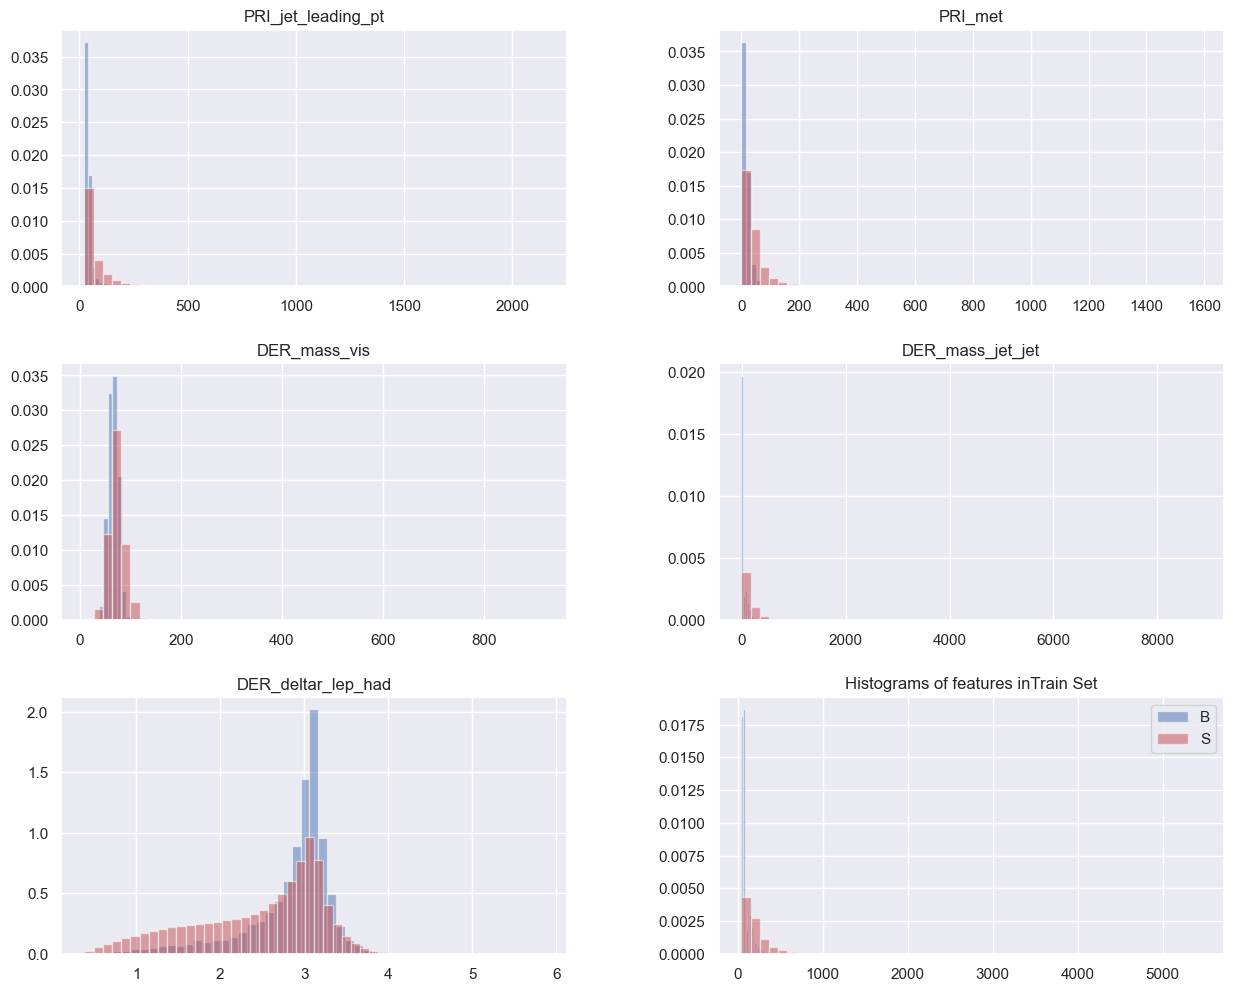

In [17]:
# Show data summary
visualize.show_histogram()

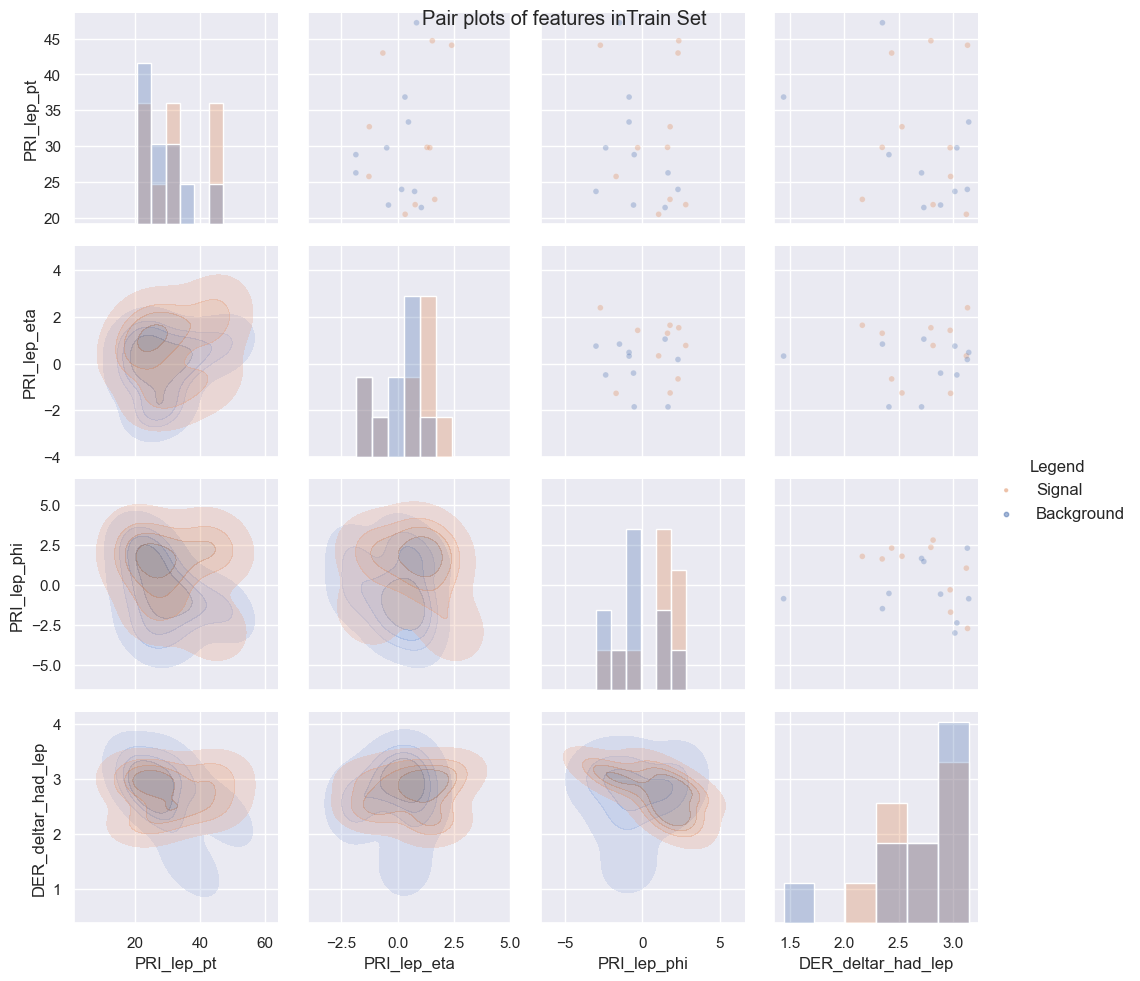

In [18]:
# Show data summary
visualize.show_pair_plots()

***
# Systematics
***
We demonstrate how `Systematics` class can be used to add systematics to a dataset

### ⚠️ Note:
`Systematics` class is one of the input of the submitted model, Participants are free to use this class and introduce systematics in their datasets

In [19]:
class Syst():
    def __init__(self, data):

        self.data = data
        self.columns = ['PRI_lep_pt', 'PRI_lep_eta','PRI_had_eta', 'DER_deltar_had_lep']
        print("==========================================")
        print("Systematics")
        print("==========================================")


    def add_systematics_to_train_data(self):
        print("[*] Adding systematics to Train set")
        # generate tes value uniformly between 0.9 and 1.1
        tes = round(np.random.uniform(0.9, 1.10), 2)
        print(f"[*] --- tes: {tes}")
        # apply systematics
        train_df_temp = self.data.train_set["data"].copy()
        train_df_temp["weights"] = self.data.train_set["weights"].copy()
        train_df_temp["labels"] = self.data.train_set["labels"].copy()
        train_data_with_systematics_temp = Systematics(
            data=train_df_temp,
            tes=tes
        ).data

        train_labels = train_data_with_systematics_temp.pop('labels')
        train_weights = train_data_with_systematics_temp.pop('weights')
        train_data_with_systematics = train_data_with_systematics_temp.copy()

        self.train_set_with_systematics = {
            "data": train_data_with_systematics,
            "labels": train_labels,
            "weights": train_weights,
            "settings": {"tes": tes, "mu":1.0}
        }

    
    def visualize_train_set(self):
        train_visualize = Dataset_visualise(
            data=data.train_set["data"],
            weights=data.train_set["weights"],
            labels=data.train_set["labels"],
            name="Train Set"
        ) 
        train_visualize.pair_plots(columns=self.columns)

    def visualize_train_set_with_systematics(self):
        train_syst_visualize = Dataset_visualise(
            data=self.train_set_with_systematics["data"],
            weights=self.train_set_with_systematics["weights"],
            labels=self.train_set_with_systematics["labels"],
            name="Train Set with systematics"
        ) 
        train_syst_visualize.pair_plots(columns=self.columns)
    

In [20]:
# Intiialize Program
syst = Syst(data=data)

Systematics


In [21]:
# Add systematics to trian data
systematics_train = syst.add_systematics_to_train_data()

[*] Adding systematics to Train set
[*] --- tes: 0.94


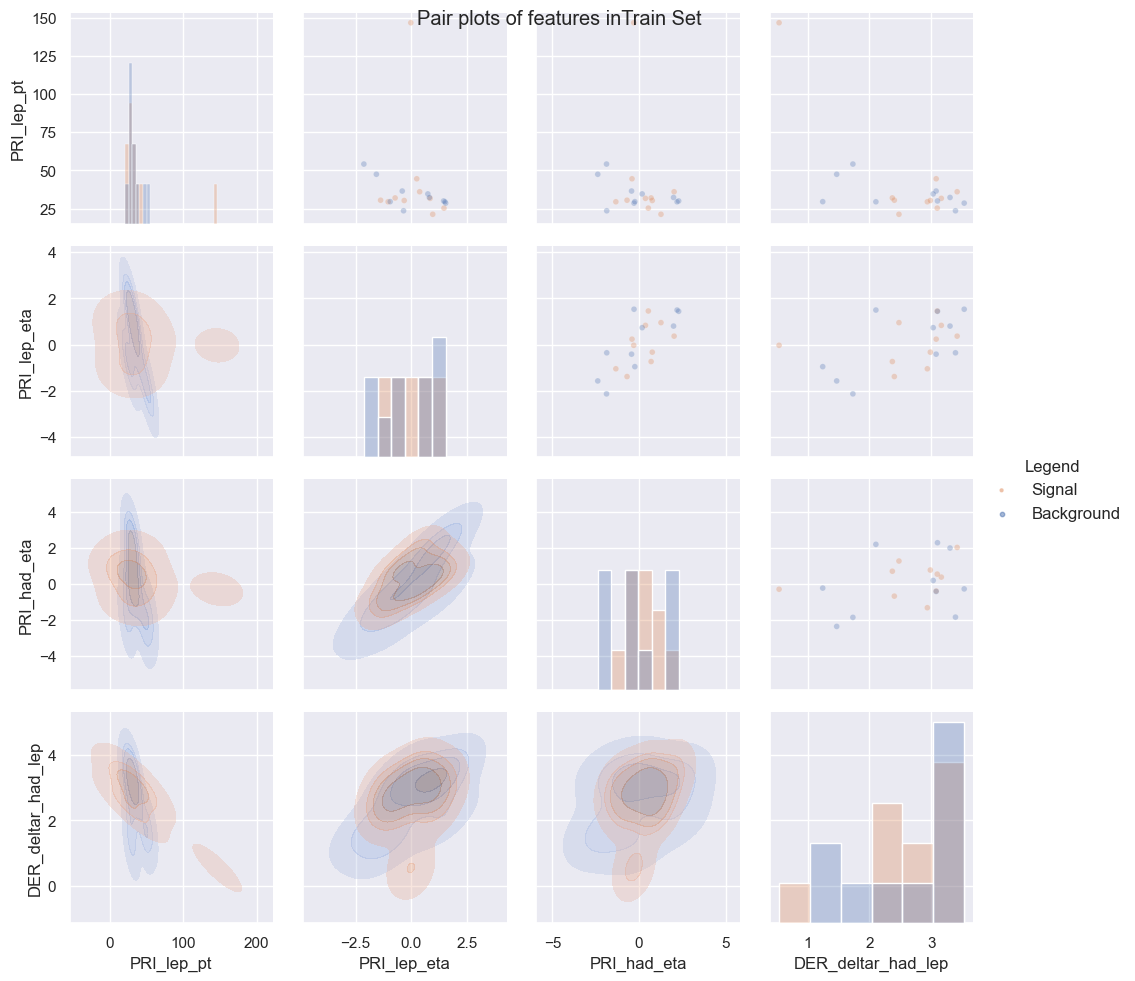

In [22]:
# Pair plots of orignal train set
syst.visualize_train_set()

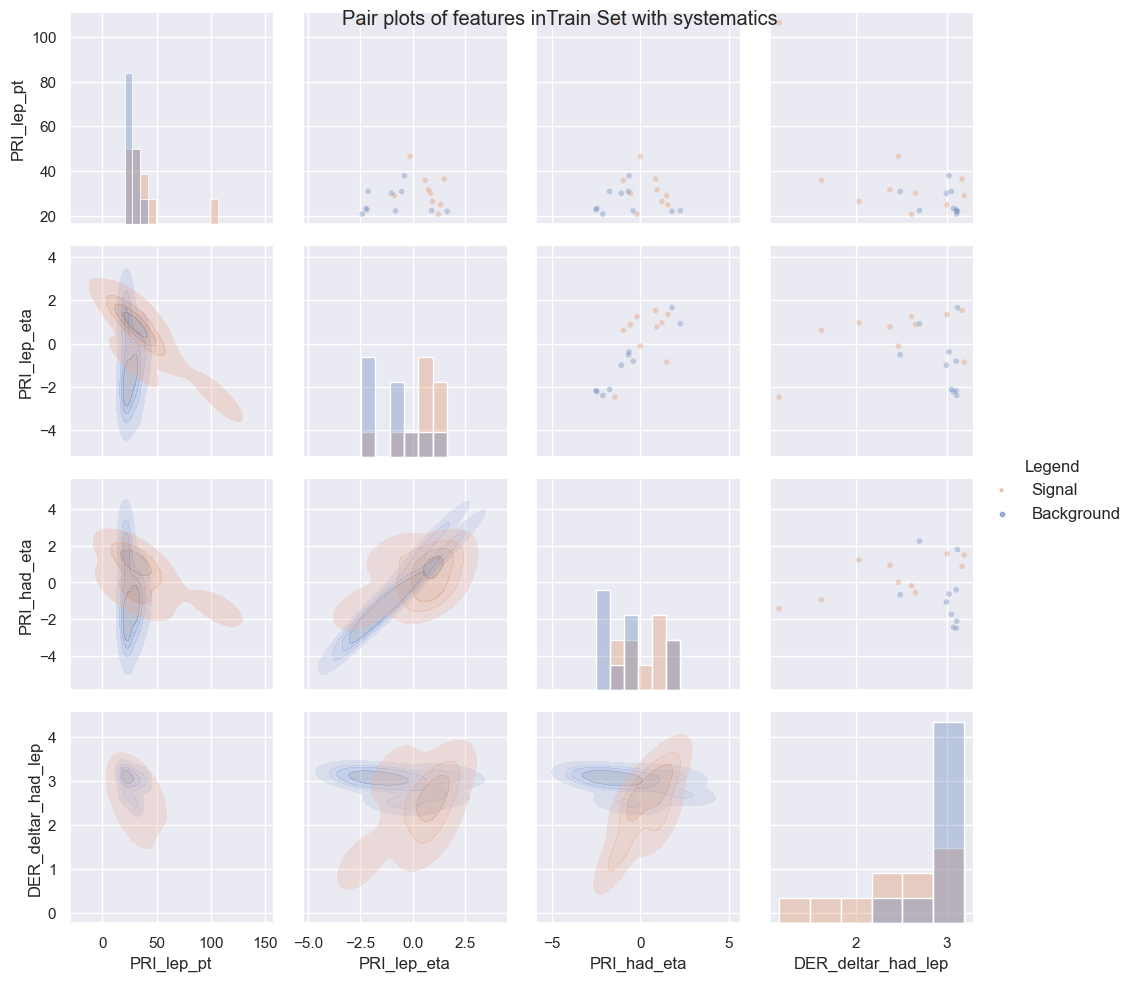

In [23]:
# Pair plots of train set with systematics
syst.visualize_train_set_with_systematics()

***
# Program
***
**`Ingestion program`** is responsible to run the submission of a participant on Codabench platform. **`Program`** is a simplified version of the **Ingestion Program** to show to participants how it runs a submission.
1. Train a model on train data
2. Predict using Test data

In [24]:
class Program():

    def __init__(self, data):

        # used to keep object of Model class to run the submission
        self.model = None
        # object of Data class used here to get the train and test sets
        self.data = data

        # results
        self.results = []

        print("==========================================")
        print("Program")
        print("==========================================")
    
    def initialize_submission(self):
        print("[*] Initializing Submmited Model")
        self.model = Model(
            train_set=self.data.train_set,
            systematics=Systematics
        )

    def fit_submission(self):
        print("[*] Calling fit method of submitted model")
        self.model.fit()

    def get_bootstraped_dataset(self, mu=1.0, tes=1.0, seed=42):

        temp_df = deepcopy(self.data.test_set["data"])
        temp_df["weights"] = self.data.test_set["weights"]
        temp_df["labels"] = self.data.test_set["labels"]

        # Apply systematics to the sampled data
        data_syst = Systematics(
            data=temp_df,
            tes=tes
        ).data

        # Apply weight scaling factor mu to the data
        data_syst['weights'][data_syst["labels"] == 1] *= mu

        data_syst.pop("labels")

        prng = RandomState(seed)
        new_weights = prng.poisson(lam=data_syst['weights'])

        data_syst['weights'] = new_weights

        return {
            "data": data_syst.drop("weights", axis=1),
            "weights": new_weights
        }

    def predict_submission(self):
        print("[*] Calling predict method of submitted model")
        # get set inxex = 0
        set_indices = np.arange(0, 1)
        # get test set indices per set (0-99)
        test_set_indices = np.arange(0, 100)

        # create a product of set and test set indices all combinations of tuples
        all_combinations = list(product(set_indices, test_set_indices))

        results_dict = {}
        for set_index, test_set_index in all_combinations:

            # random tes value (one per test set)
            tes = np.random.uniform(0.9, 1.1)
            # create a seed
            seed = (set_index*100) + test_set_index
            # get mu value of set from test settings
            set_mu = self.data.test_set["settings"]["ground_truth_mus"][set_index]

            # get bootstrapped dataset from the original test set
            test_set = self.get_bootstraped_dataset(mu=set_mu, tes=tes, seed=seed)

            predicted_dict = self.model.predict(test_set)
            predicted_dict["test_set_index"] = test_set_index

            print(f"[*] - mu_hat: {predicted_dict['mu_hat']} - delta_mu_hat: {predicted_dict['delta_mu_hat']} - p16: {predicted_dict['p16']} - p84: {predicted_dict['p84']}")

            if set_index not in results_dict:
                results_dict[set_index] = []

            results_dict[set_index].append(predicted_dict)

        # prepare results for scoring
        self.results = []
        for i in range(0, 1):
            set_result = results_dict[i]
            mu_hats, delta_mu_hats, p16, p84 = [], [], [], []
            for test_set_dict in set_result:
                mu_hats.append(test_set_dict["mu_hat"])
                delta_mu_hats.append(test_set_dict["delta_mu_hat"])
                p16.append(test_set_dict["p16"])
                p84.append(test_set_dict["p84"])

            ingestion_result_dict = {
                "mu_hats": mu_hats,
                "delta_mu_hats": delta_mu_hats,
                "p16": p16,
                "p84": p84,
            }
            self.results.append(ingestion_result_dict)

In [25]:
# Intiialize Program
program = Program(data=data)

Program


In [26]:
# Initialize submitted model
program.initialize_submission()

[*] Initializing Submmited Model


In [27]:
# Call fit method of submitted model
program.fit_submission()

[*] Calling fit method of submitted model
[*] - Generating Validation sets
[*] --- original signal: 9221.128241000004 --- original background: 2569750.604344006
[*] --- train signal: 8562.455607594999 --- train background: 2274398.627405922
[*] --- holdout_set signal: 9221.128240999999 --- holdout_set background: 2569750.6043440104
[*] - Intialize Baseline Model (NN bases Uncertainty Estimator Model)
[*] --- Training Model
[*] --- shape of train tes data (9824036, 32)
[*] --- Fitting Model
34113/34113 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step
[*] --- Predicting Holdout set done
[*] --- score =  [0.30790803 0.39061767 0.40560114 ... 0.11891245 0.9999989  0.93354905]


  0%|          | 0/10 [00:00<?, ?it/s]

29930/29930 ━━━━━━━━━━━━━━━━━━━━ 37s 1ms/step


 10%|█         | 1/10 [00:50<07:38, 50.99s/it]

30930/30930 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step


 20%|██        | 2/10 [01:42<06:48, 51.00s/it]

31893/31893 ━━━━━━━━━━━━━━━━━━━━ 36s 1ms/step


 30%|███       | 3/10 [02:33<05:59, 51.33s/it]

32817/32817 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step


 40%|████      | 4/10 [03:27<05:13, 52.22s/it]

33693/33693 ━━━━━━━━━━━━━━━━━━━━ 38s 1ms/step


 50%|█████     | 5/10 [04:21<04:23, 52.77s/it]

34517/34517 ━━━━━━━━━━━━━━━━━━━━ 39s 1ms/step


 60%|██████    | 6/10 [05:17<03:35, 53.95s/it]

35304/35304 ━━━━━━━━━━━━━━━━━━━━ 41s 1ms/step


 70%|███████   | 7/10 [06:15<02:45, 55.21s/it]

36059/36059 ━━━━━━━━━━━━━━━━━━━━ 42s 1ms/step


 80%|████████  | 8/10 [07:13<01:52, 56.28s/it]

36785/36785 ━━━━━━━━━━━━━━━━━━━━ 47s 1ms/step


 90%|█████████ | 9/10 [08:17<00:58, 58.72s/it]

37325/37325 ━━━━━━━━━━━━━━━━━━━━ 45s 1ms/step


100%|██████████| 10/10 [09:20<00:00, 56.09s/it]


[*] --- s_list shape: (30, 10)
[*] --- b_list shape: (30, 10)
[*] --- theta_list shape: (10,)
[*] --- number of bins: 30
[*] --- number of control bins: 5
[*] --- mu_hat: 1.0032074644983822 --- mu_p16: 0.9744090573985762 --- mu_p84: 1.0320058715981881 --- alpha: 1.000446981826791
[*] - Saving Model
[*] --- model path: C:\Users\alexa\Desktop\Documents\ENS Paris-Saclay\L3\Stage L3\HEP-Challenge\NN_min_saved\model.keras
[*] --- settings path: C:\Users\alexa\Desktop\Documents\ENS Paris-Saclay\L3\Stage L3\HEP-Challenge\NN_min_saved\settings.pkl
[*] --- scaler path: C:\Users\alexa\Desktop\Documents\ENS Paris-Saclay\L3\Stage L3\HEP-Challenge\NN_min_saved\scaler.pkl
[*] - Model saved


In [28]:
# Call predict method of submitted model
program.predict_submission()

[*] Calling predict method of submitted model
[*] - Testing
303255/303255 ━━━━━━━━━━━━━━━━━━━━ 377s 1ms/step
[*] - Computing Test result
[*] --- mu_hat: 0.9967925355016178
[*] --- delta_mu_hat: 0.08062498921045069
[*] --- p16: 0.9564800408963925
[*] --- p84: 1.0371050301068432
[*] --- alpha: 1.0
[*] - mu_hat: 0.9967925355016178 - delta_mu_hat: 0.08062498921045069 - p16: 0.9564800408963925 - p84: 1.0371050301068432
[*] - Testing
348269/348269 ━━━━━━━━━━━━━━━━━━━━ 484s 1ms/step
[*] - Computing Test result
[*] --- mu_hat: 0.1207377110464369
[*] --- delta_mu_hat: 0.04831165385286759
[*] --- p16: 0.0965818841200031
[*] --- p84: 0.1448935379728707
[*] --- alpha: 1.0111731126630317
[*] - mu_hat: 0.1207377110464369 - delta_mu_hat: 0.04831165385286759 - p16: 0.0965818841200031 - p84: 0.1448935379728707
[*] - Testing
357695/357695 ━━━━━━━━━━━━━━━━━━━━ 1053s 3ms/step
[*] - Computing Test result
[*] --- mu_hat: 0.17388807367608625
[*] --- delta_mu_hat: 0.052622547106697004
[*] --- p16: 0.147576800

MemoryError: Unable to allocate 43.1 MiB for an array with shape (11292674, 1) and data type float32

***
# Score
***
1. Compute Scores
2. Visualize Scores


In [ ]:
class Score():

    def __init__(self, data, program):

        self.data = data
        self.program = program

        print("==========================================")
        print("Score")
        print("==========================================")

    def compute_scores(self):
        print("[*] Computing scores")

        # loop over ingestion results
        self.rmses, self.maes, self.p16, self.p84, self.mus, self.mu_hats, self.intervals, self.coverages, self.quantiles_scores = [], [], [], [], [], [], [], [], []
        all_mus, all_p16s, all_p84s = [], [], []
        for i, (ingestion_result, mu) in enumerate(zip(self.program.results, self.data.test_set["settings"]["ground_truth_mus"])):
            
            mu_hats = ingestion_result["mu_hats"]
            delta_mu_hats = ingestion_result["delta_mu_hats"]
            p16s = ingestion_result["p16"]
            p84s = ingestion_result["p84"]

            all_mus.extend(np.repeat(mu, len(p16s)))
            all_p16s.extend(p16s)
            all_p84s.extend(p84s)

            set_rmses, set_maes = [], []
            for mu_hat, delta_mu_hat in zip(mu_hats, delta_mu_hats):
                set_rmses.append(self.RMSE_score(mu, mu_hat, delta_mu_hat))
                set_maes.append(self.MAE_score(mu, mu_hat, delta_mu_hat))
            set_interval, set_coverage, set_quantiles_score = self.Quantiles_Score(np.repeat(mu, len(p16s)), np.array(p16s), np.array(p84s))

            set_mae = np.mean(set_maes)
            set_rmse = np.mean(set_rmses)

            print("------------------")
            print(f"Set {i}")
            print("------------------")
            print(f"MAE (avg): {set_mae}")
            print(f"RMSE (avg): {set_rmse}")
            print(f"Interval: {set_interval}")
            print(f"Coverage: {set_coverage}")
            print(f"Quantiles Score: {set_quantiles_score}")

            # Save set scores in lists
            self.mus.append(mu)
            self.p16.append(p16s)
            self.p84.append(p84s)
            self.mu_hats.append(mu_hats)
            self.rmses.append(set_rmse)
            self.maes.append(set_mae)
            self.intervals.append(set_interval)
            self.coverages.append(set_coverage)
            self.quantiles_scores.append(set_quantiles_score)

        overall_interval, overall_coverage, overall_quantiles_score = self.Quantiles_Score(np.array(all_mus), np.array(all_p16s), np.array(all_p84s))

        print("\n\n==================")
        print("Overall Score")
        print("==================")
        print(f"[*] --- RMSE: {round(np.mean(self.rmses), 3)}")
        print(f"[*] --- MAE: {round(np.mean(self.maes), 3)}")
        print(f"[*] --- Interval: {round(overall_interval, 3)}")
        print(f"[*] --- Coverage: {round(overall_coverage, 3)}")
        print(f"[*] --- Quantiles score: {round(overall_quantiles_score, 3)}")

    def RMSE_score(self, mu, mu_hat, delta_mu_hat):
        """Compute the sum of MSE and MSE2."""

        def MSE(mu, mu_hat):
            """Compute the mean squared error between scalar mu and vector mu_hat."""
            return np.mean((mu_hat - mu) ** 2)

        def MSE2(mu, mu_hat, delta_mu_hat):
            """Compute the mean squared error between computed delta_mu = mu_hat - mu and delta_mu_hat."""
            adjusted_diffs = (mu_hat - mu)**2 - delta_mu_hat**2
            return np.mean(adjusted_diffs**2)

        return np.sqrt(MSE(mu, mu_hat) + MSE2(mu, mu_hat, delta_mu_hat))

    def MAE_score(self, mu, mu_hat, delta_mu_hat):
        """Compute the sum of MAE and MAE2."""

        def MAE(mu, mu_hat):
            """Compute the mean absolute error between scalar mu and vector mu_hat."""
            return np.mean(np.abs(mu_hat - mu))

        def MAE2(mu, mu_hat, delta_mu_hat):
            """Compute the mean absolute error based on the provided definitions."""
            adjusted_diffs = np.abs(mu_hat - mu) - delta_mu_hat
            return np.mean(np.abs(adjusted_diffs))

        return MAE(mu, mu_hat) + MAE2(mu, mu_hat, delta_mu_hat)

    def Quantiles_Score(self, mu, p16, p84, eps=1e-3):

        def Interval(p16, p84):
            """Compute the average of the intervals defined by vectors p16 and p84."""
            return np.mean(np.abs(p84 - p16))

        def Coverage(mu, p16, p84):
            """Compute the fraction of times scalar mu is within intervals defined by vectors p16 and p84."""
            return_coverage = np.mean((mu >= p16) & (mu <= p84))
            return return_coverage

        def f(x, n_tries, max_coverage=1e4, one_sigma = 0.6827):
                sigma68 = np.sqrt(((1-one_sigma)*one_sigma*n_tries))/n_tries

                if (x >= one_sigma-2*sigma68 and x <= one_sigma+2*sigma68):
                    out = 1
                elif (x < one_sigma-2*sigma68):
                    out = 1 + abs((x-(one_sigma-2*sigma68))/sigma68)**4
                elif (x > one_sigma+2*sigma68):
                    out = 1 + abs((x-(one_sigma+2*sigma68))/sigma68)**3
                return out

        coverage = Coverage(mu, p16, p84)
        interval = Interval(p16, p84)
        score = -np.log((interval + eps) * f(coverage, n_tries=mu.shape[0]))
        return interval, coverage, score

    def visualize_scatter(self):
        plt.figure(figsize=(6, 4))
        for i, (ingestion_result, mu) in enumerate(zip(self.program.results, self.data.test_set["settings"]["ground_truth_mus"])):
           
            mu_hat = np.mean(ingestion_result["mu_hats"])
            plt.scatter(mu, mu_hat, c='b', marker='o')
        
        plt.xlabel('Ground Truth $\mu$')
        plt.ylabel('Predicted $\mu$ (averaged for 100 test sets)')
        plt.title('Ground Truth vs. Predicted $\mu$ Values')
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.show()

    def visualize_coverage(self):

        fig = plt.figure( figsize=(5, 5))

        for idx, (mu, mu_hats, p16s, p84s) in enumerate(zip(self.mus, self.mu_hats, self.p16, self.p84)):

             # plot horizontal lines from p16 to p84
            for i, (p16, p84) in enumerate(zip(p16s, p84s)):
                plt.hlines(y=i, xmin=p16, xmax=p84, colors='b', label='p16-p84')

            plt.vlines(x=mu, ymin=0, ymax=len(p16s), colors='r', linestyles='dashed')
            plt.xlabel('mu')
            plt.ylabel('psuedo-experiments')
            plt.title(f'mu distribution - Set_{idx}')
            
        plt.show()


In [ ]:
# Initialize Score
score = Score(data=data, program=program)

In [ ]:
# Compute Score
score.compute_scores()

In [ ]:
# Visualize scatter plot of ground truth mu and predicted mu
score.visualize_scatter()

In [ ]:
# Visualize coverage
score.visualize_coverage()

***
# Submissions
***

### **Unit Testing**

It is <b><span style="color:red">important that you test your submission files before submitting them</span></b>. All you have to do to make a submission is modify the file <code>model.py</code> in the <code>sample_code_submission/</code> directory, then run this test to make sure everything works fine. This is the actual program that will be run on the server to test your submission.
<br>
Keep the sample code simple.<br>

<code>python3</code> is required for this step

### **Test Ingestion Program**
⚠️ Note: Ingestion program runs by default a small dataset. To run it on public data set `USE_PUBLIC_DATA = True`

In [ ]:
!python3 $program_dir/ingestion.py

### **Test Scoring Program**

In [ ]:
!python3 $score_dir/score.py

### **Prepare the submission**

In [ ]:
import datetime
from data_io import zipdir
the_date = datetime.datetime.now().strftime("%y-%m-%d-%H-%M")
code_submission = 'HiggsML-code_submission_' + the_date + '.zip'
zipdir(code_submission, submission_dir)
print("Submit : " + code_submission + " to the competition")
print("You can find the zip file in `HEP-Challenge/")

In [ ]:
import pandas